In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import torch.nn as nn
import cv2 as cv
import tqdm 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
from torch.autograd.variable import Variable
from utils import Logger
      
from torchvision import transforms, datasets
from PIL import Image, ImageFilter
from PIL import ImageFont, ImageDraw, ImageOps
import math

ModuleNotFoundError: No module named 'utils'

In [20]:
valid_dir  = "Dataset/gt_images/"

val_imgs   = np.sort(os.listdir(valid_dir))
len(val_imgs)

152

In [22]:
# path to the image directory
dir_data  = "Dataset/train_images/"
 
 
# listing out all file names
nm_imgs   = np.sort(os.listdir(dir_data))
len(nm_imgs)

95

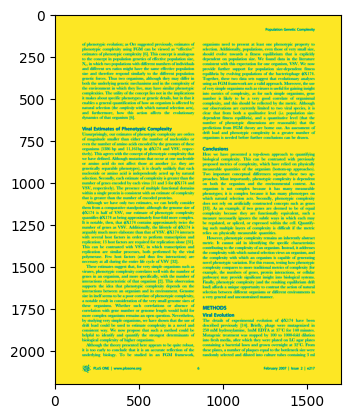

In [23]:
degraded_Images = []
Gt_Images = []
processed_train_set = []
GT_train_set =[]
for file in nm_imgs:
    if file.endswith(".png"):
        img = cv.imread(dir_data+file,cv.IMREAD_GRAYSCALE)
        plt.imshow(img)
        degraded_Images.append(img)
    if file.endswith(".png"):
        img2 = cv.imread(valid_dir+file,cv.IMREAD_GRAYSCALE)
        plt.imshow(img2)
        Gt_Images.append(img2)

In [24]:
len(degraded_Images),len(Gt_Images)

(95, 95)

In [25]:
def DetectCorners(source_img,target_img) :
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(source_img, None)
    kp2, des2 = sift.detectAndCompute(target_img, None)


    # Match descriptors
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.85 * n.distance:
            good_matches.append(m)

    # Extract matching points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    # Apply homography
    result = cv.warpPerspective(source_img, H, (target_img.shape[1], target_img.shape[0]))
    processed_train_set.append(result)
    GT_train_set.append(target_img)
    # Display result
    

In [26]:
for i in range(len(degraded_Images)):
   
   
    DetectCorners(degraded_Images[i],Gt_Images[i])
    

In [30]:
len(processed_train_set),len(GT_train_set)

(95, 95)

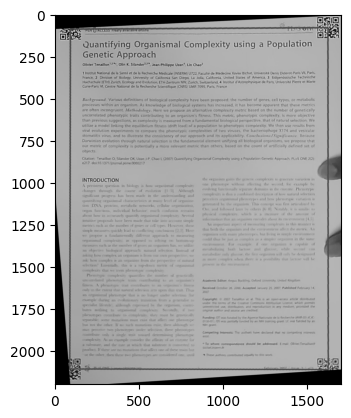

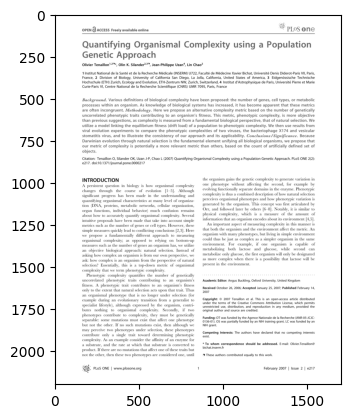

In [36]:
temp_img1 = cv.cvtColor(processed_train_set[1], cv.COLOR_BGR2RGB)
temp_img2 = cv.cvtColor(GT_train_set[1],cv.COLOR_BGR2RGB)
plt.imshow(temp_img1)
plt.show()
plt.imshow(temp_img2)
plt.show()



In [37]:
def getPatches(gt_img,train_img,patch_size):
    train_patches=[]
    gt_patches=[]
    h =  ((train_img.shape [0] // 256) +1)*256 
    w =  ((train_img.shape [1] // 256 ) +1)*256
    image_padding=np.ones((h,w))
    image_padding[:train_img.shape[0],:train_img.shape[1]]=train_img
    for j in range (0,h-256,patch_size): 
        for k in range (0,w-256,patch_size):
            train_patches.append(image_padding[j:j+256,k:k+256])
    
    h =  ((gt_img.shape [0] // 256) +1)*256 
    w =  ((gt_img.shape [1] // 256 ) +1)*256

    image_padding=np.ones((h,w))
    image_padding[:gt_img.shape[0],:gt_img.shape[1]]=gt_img

    for j in range (0,h-256,patch_size):   
        for k in range (0,w-256,patch_size):
            gt_patches.append(image_padding[j:j+256,k:k+256])  
            
    return np.array(train_patches),np.array(gt_patches)



In [44]:
%%time
x_train = []
x_validate = []
for i in range(len(processed_train_set)):
    _blur_patches , _cleanimage_patches = getPatches(processed_train_set[i], GT_train_set[i], 128+64)
    x_train.append(_blur_patches)
    x_validate.append(_cleanimage_patches)
x_train = np.concatenate(x_train, axis=0)
x_validate = np.concatenate(x_validate, axis=0)
len(x_train),len(x_validate)



CPU times: user 3.23 s, sys: 5.25 s, total: 8.48 s
Wall time: 15.5 s


(8360, 8360)

In [46]:
print(x_train.shape, x_validate.shape)

(8360, 256, 256) (8360, 256, 256)


In [47]:
class IC_Dataset(Dataset):
    
    def __init__(self, x_train, gt_train, transform=None):
        self.x_train = x_train
        self.gt_train = gt_train
        self.transform = transform
    
    def __len__(self):
        return len(self.gt_train)

    def __getitem__(self, idx):
        gt_img = self.gt_train[idx]
        train_img = self.x_train[idx]

        gt_img = np.asarray(gt_img)
        train_img = np.asarray(train_img)

        gt_img = Image.fromarray(gt_img.astype(np.uint8))
        train_img = Image.fromarray(train_img.astype(np.uint8))

        if self.transform:
            gt_img = self.transform(gt_img)
            train_img = self.transform(train_img)

        return train_img, gt_img




In [53]:
dataset = IC_Dataset(x_train, x_validate, transform=transforms.Compose(
            [transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])]))

bs = 16
data_loader = DataLoader(dataset, batch_size=bs, shuffle=True)
num_batches = len(data_loader)

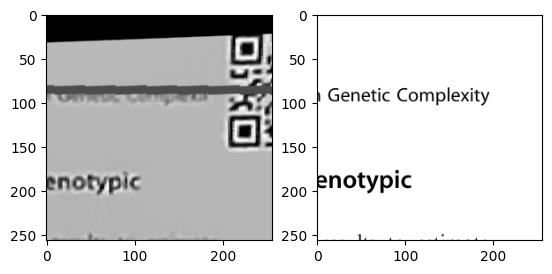

In [54]:
x,y = next(iter(data_loader))
_, ax = plt.subplots(1,2)
ax[0].imshow(x[0].squeeze(), cmap='gray')
ax[1].imshow(y[0].squeeze(), cmap='gray')

In [55]:

print(x.shape, y.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


In [56]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class GeneratorNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(GeneratorNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET :  Refer to pdf file in architecture of generator to understand more about U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET: Refer to pdf file in architecture of generator to understand more about U-net
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 256, 256)

In [57]:
class DiscriminatorNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.disc = nn.Sequential(            
            nn.Conv2d(in_channels, 64, 3, 1, 1), # layer 1 64x256x256
            nn.LeakyReLU(0.01, inplace=True),                     
            nn.MaxPool2d(2),                     # layer 2 64x128x128
            nn.Conv2d(64, 128, 3, 1, 1),         # layer 3 128x128x128
            nn.LeakyReLU(0.01, inplace=True), 
            nn.MaxPool2d(2),                     # layer 4 128x64x64
            nn.Conv2d(128, 256, 3, 1, 1),        # layer 5 256x64x64
            nn.LeakyReLU(0.01, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),                     # layer 6 256x32x32
            nn.Conv2d(256, 256, 3, 1, 1),        # layer 7 256x32x32
            nn.LeakyReLU(0.01, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),                     # layer 8 256x16x16
            nn.Conv2d(256, 256, 3, 1, 1),        # layer 9 256x16x16
            nn.LeakyReLU(0.01, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, 3, 1, 1),          # layer 10 1x16x16
        )

    def forward(self, x,y):
        input = torch.cat([x,y], axis=1)
        return self.disc(input)




In [63]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    # if torch.cuda.is_available(): 
    #     return n.cuda() 
    return n

In [64]:
discriminator = DiscriminatorNet(in_channels=2)
generator = GeneratorNet(in_channels=1, out_channels=1)

# discriminator.cuda()
# generator.cuda()

In [65]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Loss function
loss1 = nn.MSELoss()
loss2 = nn.BCELoss()
loss3 = nn.BCEWithLogitsLoss()

# Number of steps to apply to the discriminator
d_steps = 1  
# Number of epochs
num_epochs = 50

In [66]:
def test_noise():
  x,y = next(iter(data_loader))
  return Variable(x).float().cuda()

In [75]:
batch_size = 32
#shuffle = Truelogger = Logger(model_name='DE-GAN', data_name='blur')
num_test_samples = bs

for epoch in range(num_epochs):
    for n_batch, (train_batch, gt_batch) in enumerate(data_loader):

        real_data = gt_batch.float()
        noised_data = train_batch.float()
        
        # 1. Train Discriminator
        # Generate fake data
        fake_data = generator(noised_data)

        # Reset gradients
        d_optimizer.zero_grad()
        
        # 1.1 Train on Real Data
        prediction_real = discriminator(real_data, noised_data)

        # Calculate error and backpropagate
        real_data_target = torch.ones_like(prediction_real)
        loss_real = loss1(prediction_real, real_data_target)

        # 1.2 Train on Fake Data, you would need to add one more component
        prediction_fake = discriminator(fake_data, noised_data)

        # Calculate error and backpropagate
        fake_data_target = torch.zeros_like(prediction_real)
        loss_fake = loss1(prediction_fake, fake_data_target)

        loss_d = (loss_real + loss_fake)/2
        loss_d.backward(retain_graph=True)
        
        # 1.3 Update weights with gradients
        d_optimizer.step()
  
        # 2. Train Generator
        g_optimizer.zero_grad()

        # Sample noise and generate fake data
        prediction = discriminator(fake_data, real_data)
        
        # Calculate error and backpropagate
        real_data_target = torch.ones_like(prediction)
        #import pdb; pdb.set_trace();

        loss_g1 = loss1(prediction, real_data_target)
        loss_g2 = loss1(fake_data, real_data)*500
        loss_g = loss_g1 + loss_g2

        loss_g.backward()

        # Update weights with gradients
        g_optimizer.step()
                
        # Log error
        # logger.log(loss_d, loss_g, epoch, n_batch, num_batches)
        print("Discriminator Loss ",loss_d)
        print("Generator Loss ",loss_g)
        print("Epoch",epoch)



        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise())).data.cpu()
            # logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # # Display status Logs
            # logger.display_status(
            #     epoch, num_epochs, n_batch, num_batches,
            #     loss_d, loss_g, prediction_real, prediction_fake
            # )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

Discriminator Loss  tensor(0.0296, grad_fn=<DivBackward0>)
Generator Loss  tensor(82.4189, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0483, grad_fn=<DivBackward0>)
Generator Loss  tensor(70.9424, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0381, grad_fn=<DivBackward0>)
Generator Loss  tensor(78.9866, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0556, grad_fn=<DivBackward0>)
Generator Loss  tensor(61.0423, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0360, grad_fn=<DivBackward0>)
Generator Loss  tensor(78.4987, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0412, grad_fn=<DivBackward0>)
Generator Loss  tensor(71.2953, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0454, grad_fn=<DivBackward0>)
Generator Loss  tensor(72.2799, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Loss  tensor(0.0470, grad_fn=<DivBackward0>)
Generator Loss  tensor(83.1470, grad_fn=<AddBackward0>)
Epoch 0
Discriminator Lo

KeyboardInterrupt: 

In [76]:
# # Display Progress
# display.clear_output(True)
# # Display Images
# test_images = vectors_to_images(generator(test_noise())).data.cpu()
# logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
# # Display status Logs
# logger.display_status(
#     epoch, num_epochs, n_batch, num_batches,
#     loss_d, loss_g, prediction_real, prediction_fake
#             )
#  # Model Checkpoints
# logger.save_models(generator, discriminator, epoch)

AttributeError: 'function' object has no attribute 'clear_output'

In [80]:
path =''
torch.save(generator.state_dict(), path + 'generator-deblur-train1.pt')
torch.save(discriminator.state_dict(), path + 'discriminator-deblur-train1.pt')

In [81]:
model = GeneratorNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(path + 'generator-deblur-train1.pt'))
model.eval()

GeneratorNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(